# MIV Feature Selection with Somers' D

This notebook demonstrates Marginal Information Value (MIV) based feature selection using rank correlation (Somers' D) instead of traditional WOE-based Information Value.

The methodology is inspired by Revolut's MIV approach but uses:

- **Fast Somers' D** for rank correlation instead of WOE/IV
- **FastWoe's predict_proba** to get model scores at each step
- **Pairwise Somers' D** to decompose effects and understand feature contributions


In [1]:
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from fastwoe.display import StyledDataFrame
from fastwoe.metrics import gini_clustered_matrix, somersd_pairwise
from fastwoe.modeling import cumulative_gini_analysis, marginal_somersd_selection


## Load and Prepare Data

We'll use the Bank Case Study dataset to demonstrate MIV feature selection.


In [2]:
ROOT_DIR = Path.cwd().parent
df = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list[Any](df.columns)}")
print("\nFirst few rows:")
df.head()


Dataset shape: (24859, 33)

Columns: ['Account_Number', 'Account_Type', 'Final_Decision', 'Current_Delinquency_status', 'Application_Date', 'Application_Score', 'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Gross_Annual_Income', 'Home_Telephone_Number', 'Insurance_Required', 'Loan_Amount', 'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status', 'Number_of_Dependants', 'Number_of_Payments', 'Occupation_Code', 'Promotion_Type', 'Residential_Status', 'Time_at_Address', 'Time_in_Employment', 'Time_with_Bank', 'Weight_Factor', 'GB_Flag', 'Age_of_Applicant', 'Application_Month', 'Bureau_Score', 'SP_ER_Reference', 'SP_Number_Of_Searches_L6M', 'SP_Number_of_CCJs', 'Loan_to_income', 'split']

First few rows:


,Account_Number,Account_Type,Final_Decision,Current_Delinquency_status,Application_Date,Application_Score,Cheque_Card_Flag,Existing_Customer_Flag,Gross_Annual_Income,Home_Telephone_Number,...,Weight_Factor,GB_Flag,Age_of_Applicant,Application_Month,Bureau_Score,SP_ER_Reference,SP_Number_Of_Searches_L6M,SP_Number_of_CCJs,Loan_to_income,split
0,10730734532,FL,Accept,NaN,20061206,965,Y,Y,12000,N,...,2.0,NTU,28,200612,1009,2,0,0,15.50,Development
1,10803550208,VL,Decline,NaN,20060928,720,N,Y,10015,Y,...,2.0,Rejects,36,200609,784,3,0,0,29.96,Development
2,10769083290,FL,Accept,0.0,20060721,975,Y,N,11000,Y,...,2.0,Good,48,200607,940,1,2,0,45.45,Development
3,10072636331,FL,Accept,1.0,20060529,960,Y,N,16500,Y,...,2.0,Good,41,200605,902,1,1,0,31.82,Development
4,10737329597,FL,Accept,0.0,20060718,980,Y,Y,60000,Y,...,2.0,Good,37,200607,1013,1,7,0,16.67,Development


In [3]:
# Select categorical features for feature selection
categorical_features = [
    "Account_Type",
    "Cheque_Card_Flag",
    "Existing_Customer_Flag",
    "Home_Telephone_Number",
    "Insurance_Required",
    "Loan_Payment_Frequency",
    "Loan_Payment_Method",
    "Marital_Status",
    "Occupation_Code",
    "Promotion_Type",
    "Residential_Status",
]

label = "Final_Decision"
df[label] = df[label].map({"Accept": 0, "Decline": 1})

# Filter to features that exist and have reasonable cardinality
available_features = [f for f in categorical_features if f in df.columns]
print(f"Available categorical features: {available_features}")

# Check cardinality
for feat in available_features:
    n_unique = df[feat].nunique()
    print(f"{feat}: {n_unique} unique values")


Available categorical features: ['Account_Type', 'Cheque_Card_Flag', 'Existing_Customer_Flag', 'Home_Telephone_Number', 'Insurance_Required', 'Loan_Payment_Frequency', 'Loan_Payment_Method', 'Marital_Status', 'Occupation_Code', 'Promotion_Type', 'Residential_Status']
Account_Type: 2 unique values
Cheque_Card_Flag: 2 unique values
Existing_Customer_Flag: 2 unique values
Home_Telephone_Number: 2 unique values
Insurance_Required: 2 unique values
Loan_Payment_Frequency: 4 unique values
Loan_Payment_Method: 4 unique values
Marital_Status: 5 unique values
Occupation_Code: 4 unique values
Promotion_Type: 4 unique values
Residential_Status: 4 unique values


In [4]:
# Prepare feature matrix (only categorical features for now)
X = df[available_features].copy()
y = df[label].values

# Remove rows with too many missing values
missing_threshold = 0.5
valid_mask = (X.isna().sum(axis=1) / len(X.columns)) < missing_threshold
X = X[valid_mask].copy()
y = y[valid_mask]

print(f"Final dataset shape: {X.shape}")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")
print(f"Bad rate: {y.mean():.2%}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")


Final dataset shape: (24859, 11)
Target distribution: {0: 22262, 1: 2597}
Bad rate: 10.45%

Train: 17401, Test: 7458


## Run MIV Feature Selection

Now we'll run the MIV feature selection using Somers' D rank correlation.


In [5]:
# Run MIV feature selection
result = marginal_somersd_selection(
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    min_miv=0.01,  # Minimum marginal Somers' D threshold
    max_features=10,  # Maximum number of features to select
    correlation_threshold=0.6,  # Maximum correlation between features
    ties="y",
    random_state=42,
)


Calculating univariate Somers' D for all features...

Step 1: Selected 'Cheque_Card_Flag' (Somers' D: 0.4515)
Step 2: Selected 'Residential_Status' (Marginal Somers' D: 0.2806)
Step 3: Selected 'Insurance_Required' (Marginal Somers' D: 0.2167)
Step 4: Selected 'Loan_Payment_Frequency' (Marginal Somers' D: 0.2096)
Step 5: Selected 'Occupation_Code' (Marginal Somers' D: 0.1822)
Step 6: Selected 'Promotion_Type' (Marginal Somers' D: 0.1790)
Step 7: Selected 'Marital_Status' (Marginal Somers' D: 0.1746)
Step 8: Selected 'Loan_Payment_Method' (Marginal Somers' D: 0.1684)
Step 9: Selected 'Home_Telephone_Number' (Marginal Somers' D: 0.0659)
Step 10: Selected 'Account_Type' (Marginal Somers' D: 0.0523)

Reached max_features limit (10)


In [6]:
# Display results as styled DataFrame
results_df = pd.DataFrame(
    {
        "Feature": result["selected_features"],
        "Marginal Somers' D": result["miv_history"],
    }
)

StyledDataFrame(
    results_df,
    title="MIV Feature Selection Results",
    subtitle=f"Selected {len(result['selected_features'])} features using marginal Somers' D",
    highlight_cols=["Marginal Somers' D"],
    precision=4,
)


Feature,Marginal Somers' D
Cheque_Card_Flag,0.4515
Residential_Status,0.2806
Insurance_Required,0.2167
Loan_Payment_Frequency,0.2096
Occupation_Code,0.1822
Promotion_Type,0.1790
Marital_Status,0.1746
Loan_Payment_Method,0.1684
Home_Telephone_Number,0.0659
Account_Type,0.0523


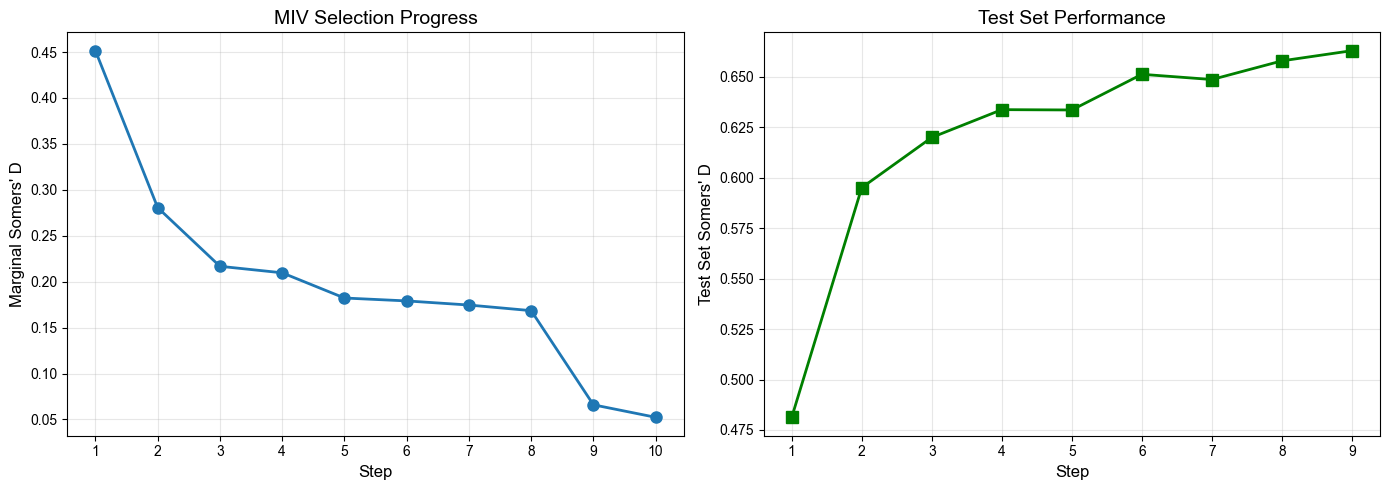

In [7]:
# Plot MIV history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MIV progression
ax1.plot(
    range(1, len(result["miv_history"]) + 1), result["miv_history"], "o-", linewidth=2, markersize=8
)
ax1.set_xlabel("Step", fontsize=12)
ax1.set_ylabel("Marginal Somers' D", fontsize=12)
ax1.set_title("MIV Selection Progress", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(result["miv_history"]) + 1))

# Test performance progression
if result["test_performance"]:
    ax2.plot(
        range(1, len(result["test_performance"]) + 1),
        result["test_performance"],
        "s-",
        linewidth=2,
        markersize=8,
        color="green",
    )
    ax2.set_xlabel("Step", fontsize=12)
    ax2.set_ylabel("Test Set Somers' D", fontsize=12)
    ax2.set_title("Test Set Performance", fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(1, len(result["test_performance"]) + 1))

plt.tight_layout()
plt.show()


## Pairwise Somers' D for Effect Decomposition

We can use pairwise Somers' D to decompose the effects of different features or segments.


In [8]:
# Get model scores for decomposition analysis
final_model = result["model"]
train_scores = final_model.predict_proba(X_train[result["selected_features"]])[:, 1]
test_scores = final_model.predict_proba(X_test[result["selected_features"]])[:, 1]

# Create a DataFrame with scores and labels for decomposition
decomp_df = pd.DataFrame(
    {
        "score": test_scores,
        "label": y_test,
        "split": df.loc[X_test.index, "split"].values if "split" in df.columns else "Test",
    }
)

# Calculate overall Gini
pos_scores = decomp_df[decomp_df["label"] == 1]["score"].values
neg_scores = decomp_df[decomp_df["label"] == 0]["score"].values
overall_gini = somersd_pairwise(pos_scores, neg_scores)

print(f"Overall Gini (Test Set): {overall_gini:.4f}")

# If we have split information, decompose by split
if "split" in decomp_df.columns:
    gini_matrix, global_gini = gini_clustered_matrix(decomp_df, "score", "label", "split")
    print(f"\nGlobal Gini: {global_gini:.4f}")

    # Display styled Gini matrix
    StyledDataFrame(
        gini_matrix.round(4),
        title="Gini Matrix by Split",
        subtitle="Pairwise Somers' D (Gini) decomposition across data splits",
        highlight_cols=list(gini_matrix.columns),
        precision=4,
    )


Overall Gini (Test Set): 0.6651

Global Gini: 0.6651


## Cumulative Gini Analysis with Multiple Score Vectors

This demonstrates how to analyze cumulative Gini when you have multiple score vectors (e.g., from different models or credit checks).


In [9]:
# Step 1: Base model score (from FastWoe)
base_score = test_scores.copy()

# Step 2: Define business rules that adjust the score
# In practice, these would be policy rules, overrides, or risk adjustments

# Rule 1: Policy rule - High risk segment (no home phone + high loan-to-income)
# This rule applies a negative adjustment for high-risk applicants
test_df = df.loc[X_test.index].copy()
if "Home_Telephone_Number" in test_df.columns and "Loan_to_income" in test_df.columns:
    # High risk: no home phone AND loan-to-income > 0.5
    high_risk_mask = (
        test_df["Home_Telephone_Number"].isna() | (test_df["Home_Telephone_Number"] == "N")
    ) & (test_df["Loan_to_income"] > 0.5)
    rule1_adjustment = np.where(high_risk_mask, -0.15, 0.0)  # Negative adjustment
    has_rule1 = np.ones(len(X_test), dtype=bool)
else:
    # Fallback: simulate based on available features
    high_risk_mask = np.random.binomial(1, 0.1, len(X_test)).astype(bool)
    rule1_adjustment = np.where(high_risk_mask, -0.15, 0.0)
    has_rule1 = np.ones(len(X_test), dtype=bool)

# Rule 2: Positive adjustment for existing customers
if "Existing_Customer_Flag" in test_df.columns:
    existing_customer = test_df["Existing_Customer_Flag"] == "Y"
else:
    existing_customer = np.random.binomial(1, 0.3, len(X_test)).astype(bool)
rule2_adjustment = np.where(existing_customer, 0.10, 0.0)  # Positive adjustment
has_rule2 = np.ones(len(X_test), dtype=bool)
# Rule 3: Occupation-based risk adjustment
if "Occupation_Code" in test_df.columns:
    # Use the least frequent occupation codes as higher risk (policy rule)
    occ_counts = test_df["Occupation_Code"].value_counts()
    # Select the 2 least frequent occupations as higher risk
    high_risk_occ_codes = occ_counts.tail(2).index.tolist()
    high_risk_occupations = test_df["Occupation_Code"].isin(high_risk_occ_codes)
else:
    high_risk_occupations = np.random.binomial(1, 0.2, len(X_test)).astype(bool)
rule3_adjustment = np.where(high_risk_occupations, -0.08, 0.0)
has_rule3 = np.ones(len(X_test), dtype=bool)
# Step 3: Build cumulative scores
# Score after base model
score_base = base_score.copy()

# Score after adding Rule 1
score_with_rule1 = np.clip(score_base + rule1_adjustment, 0, 1)

# Score after adding Rule 2
score_with_rule2 = np.clip(score_with_rule1 + rule2_adjustment, 0, 1)

# Final score after all rules
final_score = np.clip(score_with_rule2 + rule3_adjustment, 0, 1)

# Create score dictionary for cumulative analysis
score_dict = {
    "Base_Model": score_base,
    "+ Policy_Rule_1": score_with_rule1,
    "+ Existing_Customer_Rule": score_with_rule2,
    "Final_Score": final_score,
}

# All scores are available for all samples (rules apply universally)
availability_mask = {
    "Base_Model": np.ones(len(X_test), dtype=bool),
    "+ Policy_Rule_1": has_rule1,
    "+ Existing_Customer_Rule": has_rule2,
    "Final_Score": has_rule3,
}

print("Score components:")
print(f"Base Model: {len(X_test)} samples")
print(
    f"Rule 1 (High Risk Policy): Applied to {high_risk_mask.sum()} samples ({high_risk_mask.mean():.1%})"
)
print(
    f"Rule 2 (Existing Customer): Applied to {existing_customer.sum()} samples ({existing_customer.mean():.1%})"
)
print(
    f"Rule 3 (Occupation Risk): Applied to {high_risk_occupations.sum()} samples ({high_risk_occupations.mean():.1%})"
)
print(f"\nFinal score range: [{final_score.min():.3f}, {final_score.max():.3f}]")

Score components:
Base Model: 7458 samples
Rule 1 (High Risk Policy): Applied to 238 samples (3.2%)
Rule 2 (Existing Customer): Applied to 809 samples (10.8%)
Rule 3 (Occupation Risk): Applied to 1228 samples (16.5%)

Final score range: [0.000, 1.000]


In [10]:
# Run cumulative Gini analysis
cumulative_results = cumulative_gini_analysis(
    score_dict, y_test, availability_mask=availability_mask, ties="y"
)

# Display styled cumulative results
StyledDataFrame(
    cumulative_results,
    title="Cumulative Gini Analysis: Base Score + Rules",
    subtitle="Gini coefficient progression showing contribution of base model and each business rule",
    highlight_cols=["gini", "marginal_gini"],
    precision=4,
)


step,score_name,gini,marginal_gini,n_samples,n_pos,n_neg
0,baseline,0.0000,0.0000,7458,779,6679
1,Base_Model,0.6651,0.6651,7458,779,6679
2,+ Policy_Rule_1,0.6642,-0.0009,7458,779,6679
3,Final_Score,0.6598,-0.0044,7458,779,6679
4,+ Existing_Customer_Rule,0.6554,-0.0044,7458,779,6679
